# Exploratory data analysis

In [1]:
!pip install gensim
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Importing important libraries

In [2]:
import numpy as np                                          # Numerical Computing
import math                                                 # Numerical Computing
import pandas as pd                                         # Data Handling

import seaborn as sns                                       # Visualization
import matplotlib.pyplot as plt                             # Visualization
from wordcloud import WordCloud, STOPWORDS                  # Visualization
import re                                                   # Regex & String Utilities
import string                                               # Regex & String Utilities

from nltk.stem.wordnet import WordNetLemmatizer             # NLP Preprocessing
from textblob import TextBlob                               # Sentiment Analysis

from sklearn.feature_extraction.text import CountVectorizer # Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer # Feature Extraction
from sklearn.model_selection import train_test_split        # Data Splitting
from sklearn.manifold import TSNE                           # Dimensionality Reduction

from google.colab import drive                              # Google Drive Integration (for Colab)

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read dataset
Dataset = pd.read_csv('/content/drive/MyDrive/TCC/train.csv')

In [5]:
#storing all the labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [6]:
#New column 'any_label' for the comments which has any one of the label and can be considered as toxic comment.
Dataset['any_label'] = (Dataset[labels].sum(axis=1)>0)*1

In [7]:
#drop id column
Dataset = Dataset.drop('id', axis =1)

### Class Distribution

In [8]:
# Clean vs Toxic count
clean_count = (Dataset['any_label'] == 0).sum()
toxic_count = (Dataset['any_label'] == 1).sum()

print('-----Clean Vs. Toxic -----')
print('Clean comments', clean_count)
print('Toxic comments', toxic_count)
print(f"Toxic %: {toxic_count / (clean_count + toxic_count) * 100:.2f}%\n")

-----Clean Vs. Toxic -----
Clean comments 143346
Toxic comments 16225
Toxic %: 10.17%



Only around 10% of the comments are toxic, while the remaining 90% are clean. This indicates a highly imbalanced dataset.

In [9]:
print('-----All kinds of toxicity-----')
for i in labels:
    print(i, ':', Dataset[i].sum())

-----All kinds of toxicity-----
toxic : 15294
severe_toxic : 1595
obscene : 8449
threat : 478
insult : 7877
identity_hate : 1405


Among all categories, toxic has the highest frequency (15,294), followed by obscene (8,449) and insult (7,877). The rarest categories are threat (478) and identity hate (1,405), highlighting a strong imbalance across labels.

In [10]:
# Let's look at one example comment for each class label
for label in labels:
    example = Dataset[Dataset[label] == 1]['comment_text'].iloc[0]
    print(f"\n{label.upper()}:\n", example)


TOXIC:
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

SEVERE_TOXIC:
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

OBSCENE:
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

THREAT:
 Hi! I am back again!
Last warning!
Stop undoing my edits or die!

INSULT:
 COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

IDENTITY_HATE:
 You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!



From the sample comments we can see that:
- Some comments belong to **multiple categories simultaneously**  
  (e.g., the same comment is marked as *toxic, severe_toxic, obscene, and insult*).  
- This confirms that the problem is a **multi-label classification task**,  
  not a simple single-label classification.  

In [11]:
print("----- Clean Comment -----")
print(Dataset.loc[Dataset["any_label"] == 0, "comment_text"].iloc[0])

----- Clean Comment -----
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


We can clearly see that our comments contain lots of punctuations, digits, space, links etc. We will clean the comments in text preprocessing section of this notebook. Before that we will visualize raw comments. As, raw comments contain more meaningful insights

## Target Variable Distribution


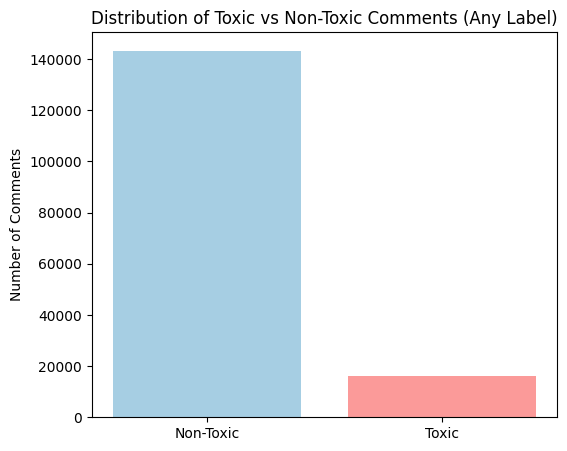

In [12]:
# Count of non-toxic vs toxic
any_toxic_counts = Dataset['any_label'].value_counts()

# Bar plot
plt.figure(figsize=(6,5))
plt.bar(['Non-Toxic', 'Toxic'], any_toxic_counts.values, color=['#a6cee3','#fb9a99'])
plt.ylabel("Number of Comments")
plt.title("Distribution of Toxic vs Non-Toxic Comments (Any Label)")
plt.show()

The dataset is heavily imbalanced: out of all comments, around 90% are non-toxic (~ 143,000) while only 10% are toxic (~16,000). This skew suggests that any baseline or advanced model may be biased towards predicting the majority (non-toxic) class, and imbalance handling strategies (e.g., class weights, resampling) may be required.

To check how all the toxic labels distributed

In [13]:
labels_count = Dataset[labels].sum().sort_values()

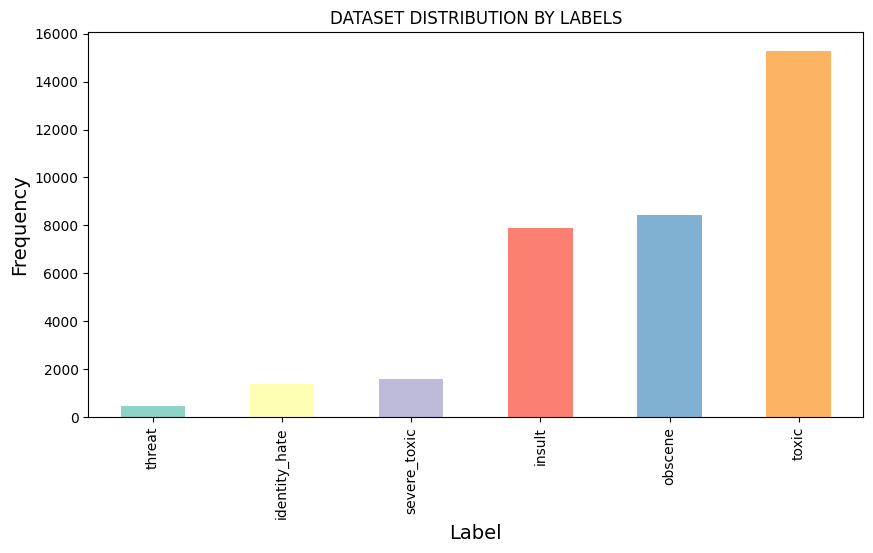

In [14]:
#visualizing the frequency of different types of comments like toxic, severe toxic, obscene, threat, insult or identity_hate
plt.figure(figsize=(10,5))
labels_count.plot(kind = 'bar', title = 'Frequency', color = sns.color_palette('Set3'))
plt.title('DATASET DISTRIBUTION BY LABELS')
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Label', fontsize=14)
plt.show()

Among all the offensive comments, the majority are labeled as toxic, while the least frequent label is threat. This shows that most toxic behavior in the dataset is general toxicity, and more extreme forms like threats are relatively rare.

In [15]:
# Print exact counts and percentages
label_percentages = (labels_count / len(Dataset) * 100).round(2)
print("Label Counts:\n", labels_count)
print("\nLabel Percentages (% of total comments):\n", label_percentages)

Label Counts:
 threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

Label Percentages (% of total comments):
 threat           0.30
identity_hate    0.88
severe_toxic     1.00
insult           4.94
obscene          5.29
toxic            9.58
dtype: float64


This imbalance highlights that models may struggle to learn minority categories without targeted techniques such as oversampling or class-weighting.

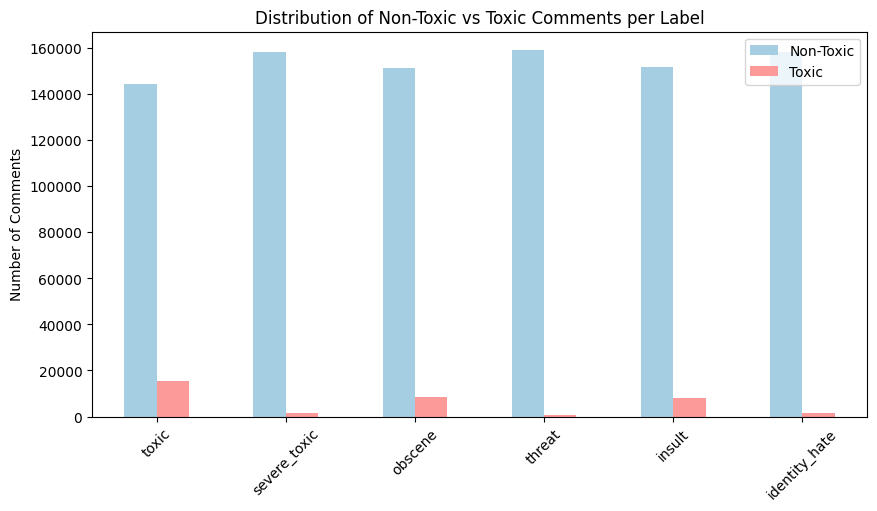

In [16]:
# Prepare a DataFrame for plotting
label_counts = []
for col in labels:
    counts = Dataset[col].value_counts()
    label_counts.append([counts.get(0,0), counts.get(1,0)])  # 0 = non-toxic, 1 = toxic

plot_df = pd.DataFrame(label_counts, columns=['Non-Toxic','Toxic'], index=labels)

# Plot grouped bar chart
plot_df.plot(kind='bar', figsize=(10,5), color=['#a6cee3','#fb9a99'])
plt.ylabel("Number of Comments")
plt.title("Distribution of Non-Toxic vs Toxic Comments per Label")
plt.xticks(rotation=45)
plt.show()


Across all labels, the non-toxic class overwhelmingly dominates. For example, while the “toxic” label has ~ 15k toxic comments, it is outnumbered by ~ 143k non-toxic comments. Rare labels such as threat (<500 toxic samples) and identity hate (~1.4k toxic samples) have extremely small representation compared to their non-toxic counterparts. This further confirms the multi-label imbalance problem, which must be addressed before modeling.

### Comments with multiple labels

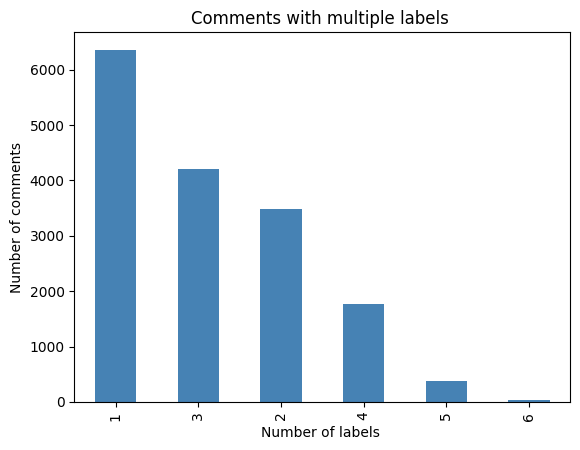

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64


In [17]:
category_count = Dataset[labels].sum(axis=1)
category_count[category_count>0].value_counts().plot.bar(color = 'steelblue')

plt.xlabel("Number of labels ")
plt.ylabel("Number of comments")
plt.title("Comments with multiple labels ")
plt.show()
print(category_count.value_counts())

More than 6000 comments have one label and there are 31 comments which have all the labels on it making it extremely toxic. This confirms that the problem is truly a multi-label classification task, where a single comment can exhibit multiple forms of toxicity simultaneously.

Lets look at the comments which have all label tags

In [18]:
# Select rows where all labels are 1
all_labels = Dataset[(Dataset[labels] == 1).all(axis=1)]

print(f"Number of comments with all 6 labels: {len(all_labels)}\n")
print("Sample comments with all labels:\n")
for comment in all_labels['comment_text'].head(3):  # show only first 3
    print("-"*80)
    print(comment)

Number of comments with all 6 labels: 31

Sample comments with all labels:

--------------------------------------------------------------------------------
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.
--------------------------------------------------------------------------------
SHUT UP, YOU FAT POOP, OR I WILL KICK YOUR ASS!!!
--------------------------------------------------------------------------------
You're a stupid cunt 

Fuck you dumb arse, your mum has a hairy cunt and I hope and pray that you die, no, fuck that, I wish you would die, if I had three wishes, one of them would be to have you dead, and the others would be so that everyone you knew hated your cunt like face.


## Raw Data Visualization:

In [19]:
dataset_eda = Dataset[['comment_text', 'any_label']].copy()

### Univariate Analysis

#### 1. Length-Based Features

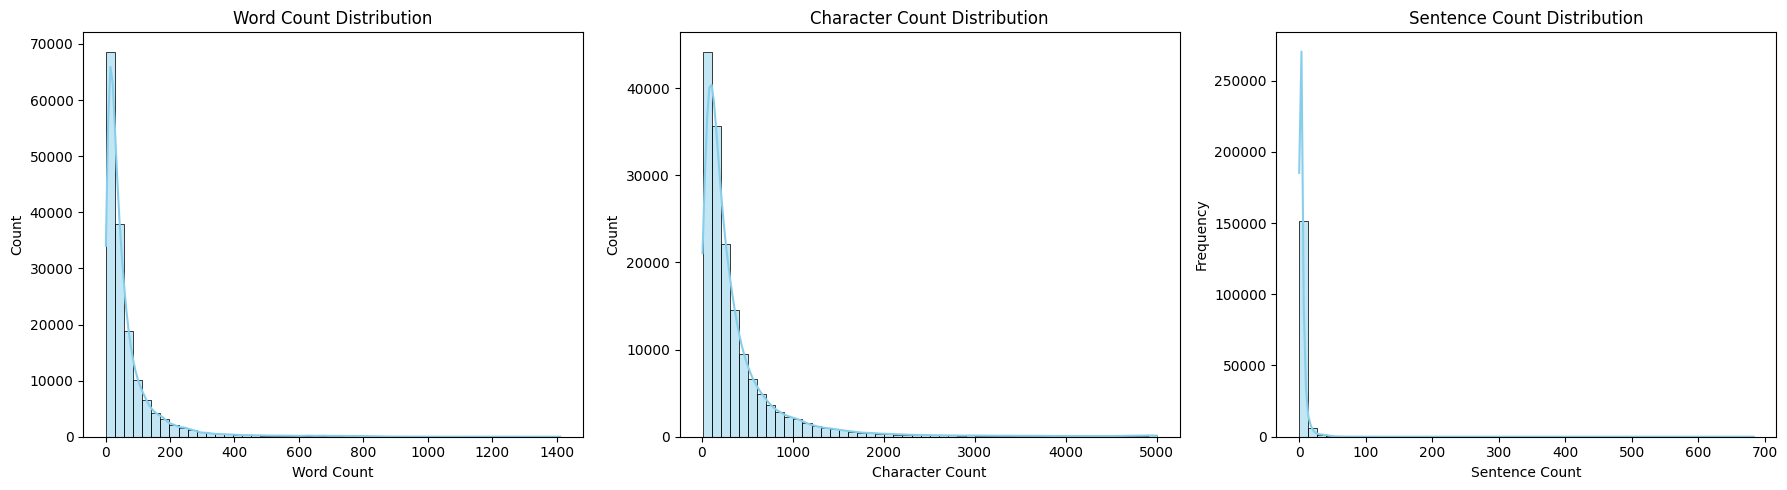

In [20]:
dataset_eda['words_count'] = dataset_eda['comment_text'].apply(lambda x: len(x.split()))
dataset_eda['char_count'] = dataset_eda['comment_text'].apply(lambda x: len(x))
dataset_eda["sentence_count"] = dataset_eda["comment_text"].apply(lambda x: len(re.split(r'[.!?]+', str(x))) - 1)

fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(dataset_eda['words_count'], bins=50, kde=True, color="skyblue", ax=axes[0])
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Word Count")

sns.histplot(dataset_eda['char_count'], bins=50, kde=True, color="skyblue", ax=axes[1])
axes[1].set_title("Character Count Distribution")
axes[1].set_xlabel("Character Count")

sns.histplot(dataset_eda['sentence_count'], bins=50, kde=True, color="skyblue", ax=axes[2])
axes[2].set_title("Sentence Count Distribution")
axes[2].set_xlabel("Sentence Count")

plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

The distributions of word count, character count, and sentence count are all right-skewed, with most comments being relatively short. The majority of comments have fewer than 100 words, 500 characters, and only a handful of sentences (typically 1–3). Extreme outliers exist with very long comments, but they are rare. Since word count and character count are highly correlated, only one of them may be needed as a feature. Sentence count, however, provides additional structural information that could be useful for modeling.

In [21]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
dataset_eda["stopwords_count"] = dataset_eda["comment_text"].apply(lambda x: len([c for c in str(x).split() if c in stopword]))

#### 2. Symbol & Style Features

In [23]:
dataset_eda['punctuation_count'] = dataset_eda['comment_text'].apply(
    lambda x: sum([1 for char in str(x) if char in string.punctuation]) # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
)
# Count number of hashtags in each comment
dataset_eda["hashtag_count"] = dataset_eda["comment_text"].str.count(r"#")
# Count number of hashtags in each comment
dataset_eda["mentions_count"] = dataset_eda["comment_text"].str.count(r"@")
# Count number of hashtags in each comment
dataset_eda["asterisk_count"] = dataset_eda["comment_text"].str.count(r"\*") #\ before * means the real asterisk symbol and not 0 or more

print(f"Mean hashtag count: {dataset_eda['hashtag_count'].mean():.2f}")
print(f"Mean punctuation count: {dataset_eda['punctuation_count'].mean():.2f}")
print(f"Mean mentions count: {dataset_eda['mentions_count'].mean():.2f}")
print(f"Mean asterisk count: {dataset_eda['asterisk_count'].mean():.2f}")

Mean hashtag count: 0.04
Mean punctuation count: 15.89
Mean mentions count: 0.01
Mean asterisk count: 0.03


On average, comments contain very few special symbols. Hashtags and mentions appear rarely, while punctuation is naturally more frequent due to sentence structure. Interestingly, toxic comments tend to use hashtags and asterisks more often, making them potential distinguishing features.

#### 3. N-gram Analysis

In [24]:
def plot_top_ngrams(corpus, ngram_range=(1,1), top_n=15, title="Top N-grams"):

    # Vectorize text
    vec = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    # Frequency dictionary
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    ngrams, counts = zip(*words_freq)

    # Plot
    plt.figure(figsize=(12,6))
    sns.barplot(x=list(counts), y=list(ngrams), hue=list(ngrams), palette="Reds_r", legend=False)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("N-grams")
    plt.show()

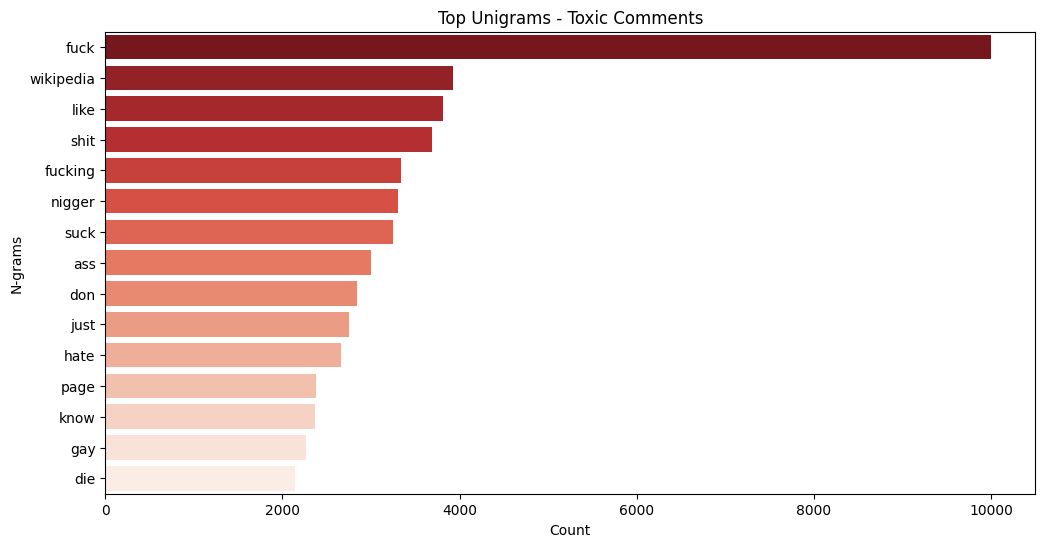

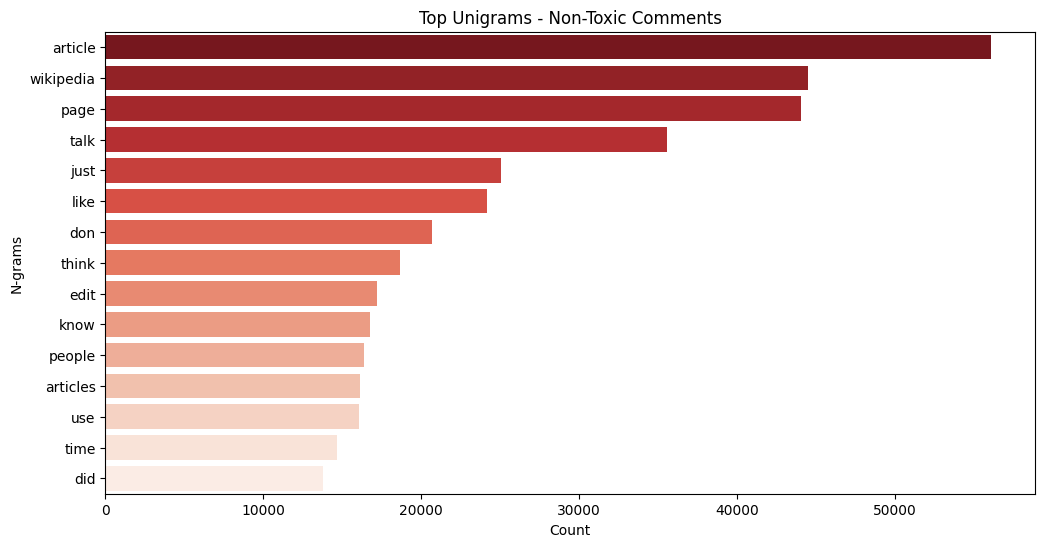

In [25]:
toxic_comments = Dataset[Dataset['any_label']==1]['comment_text']
non_toxic_comments = Dataset[Dataset['any_label']==0]['comment_text']

# Unigrams
plot_top_ngrams(toxic_comments, ngram_range=(1,1), title="Top Unigrams - Toxic Comments")
plot_top_ngrams(non_toxic_comments, ngram_range=(1,1), title="Top Unigrams - Non-Toxic Comments")

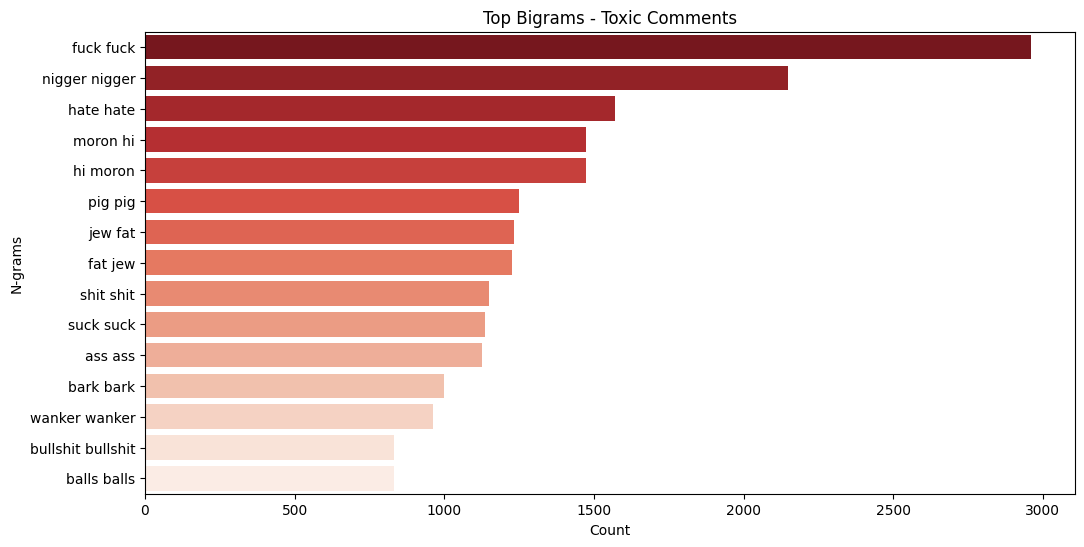

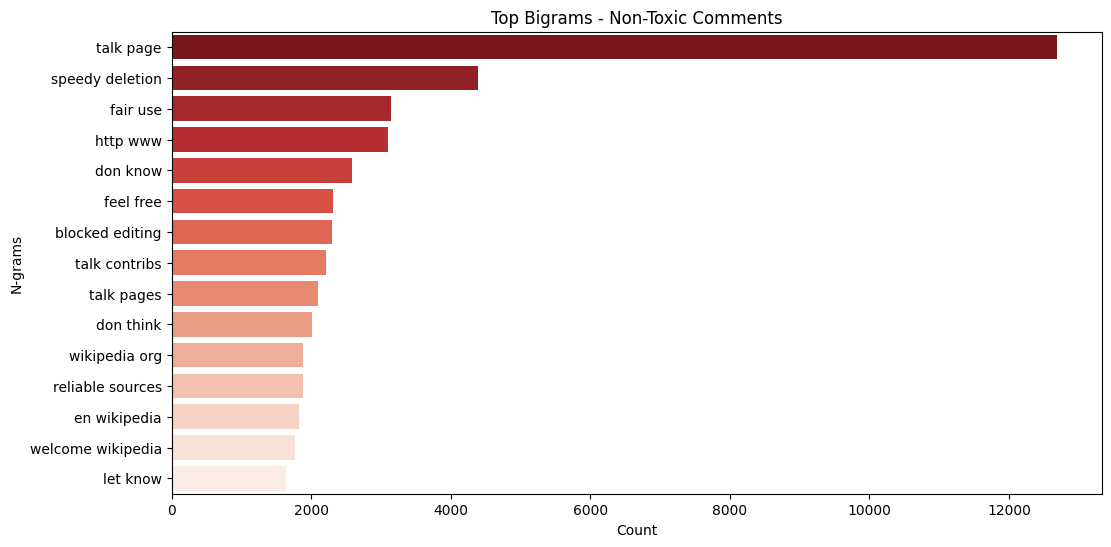

In [26]:
# Bigrams
plot_top_ngrams(toxic_comments, ngram_range=(2,2), title="Top Bigrams - Toxic Comments")
plot_top_ngrams(non_toxic_comments, ngram_range=(2,2), title="Top Bigrams - Non-Toxic Comments")

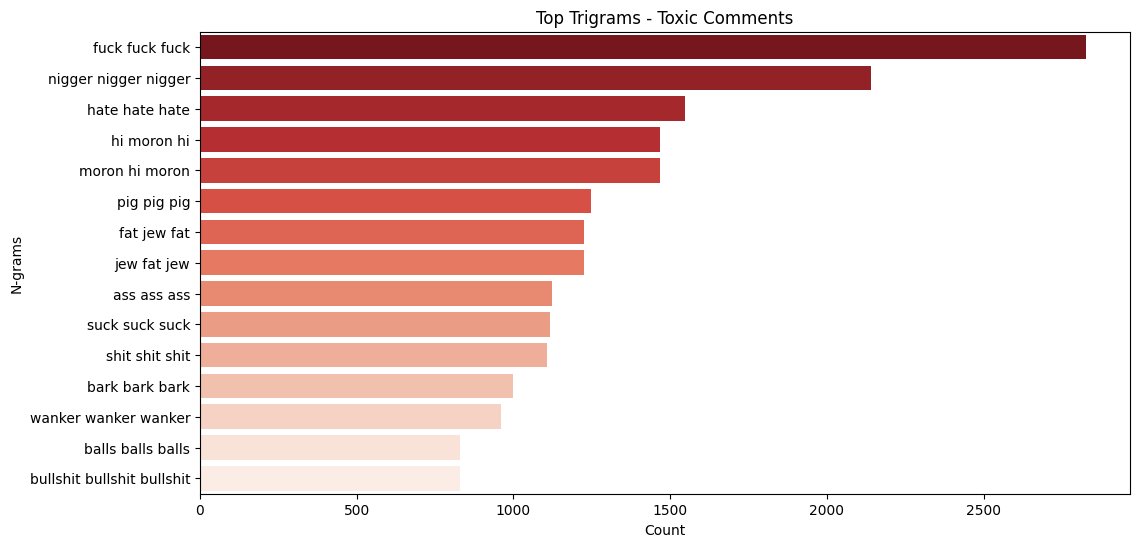

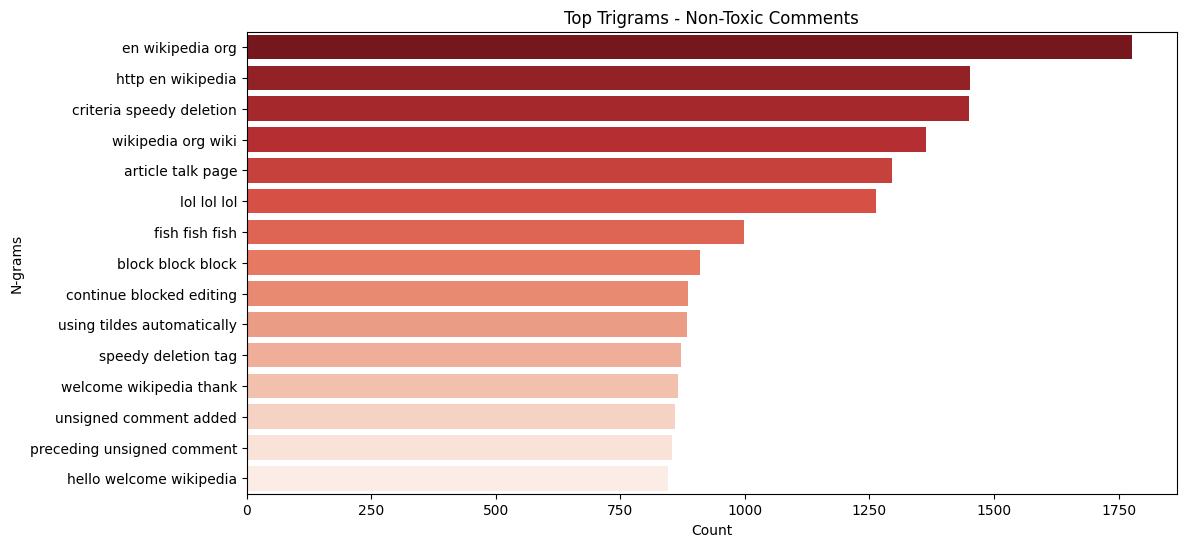

In [27]:
# Trigrams
plot_top_ngrams(toxic_comments, ngram_range=(3,3), title="Top Trigrams - Toxic Comments")
plot_top_ngrams(non_toxic_comments, ngram_range=(3,3), title="Top Trigrams - Non-Toxic Comments")

Non-toxic comments are dominated by neutral, content-focused terms like article, wikipedia, edit, page, people. This reflects constructive discussion and collaboration, typical of Wikipedia talk pages.

Toxic comments, in contrast, are dominated by profanity, slurs, and aggressive terms such as fuck, shit, nigger, gay, die, hate. Even when neutral words (e.g., wikipedia, page, know) appear, they are often mixed with insults, showing how toxic language blends with context.


👉 Overall, the n-gram analysis shows that toxicity is expressed through a mix of obscene vocabulary, abusive phrases, and repetitive patterns, while non-toxic comments are centered around constructive discussion.
This confirms that including uni/bi/tri-gram features (via TF-IDF or embeddings) can significantly improve toxic comment classification.

#### 4. WordCloud

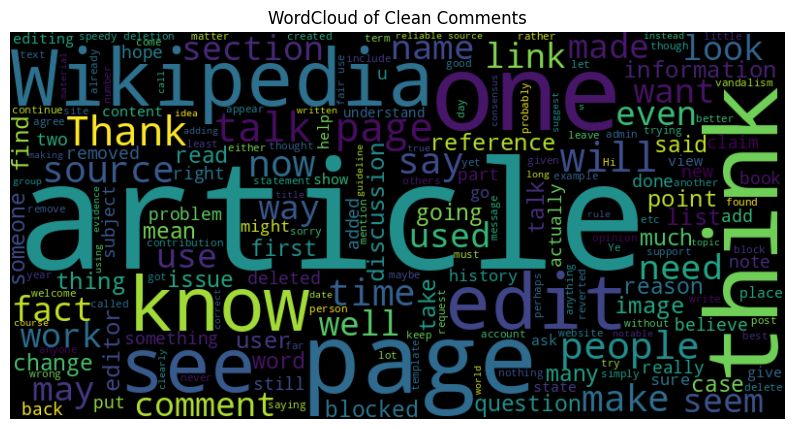

In [28]:
from wordcloud import WordCloud, STOPWORDS
# clean only
clean_comments = Dataset[Dataset['any_label']==0]['comment_text']

clean_text = " ".join(clean_comments)
wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(clean_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Clean Comments")
plt.show()

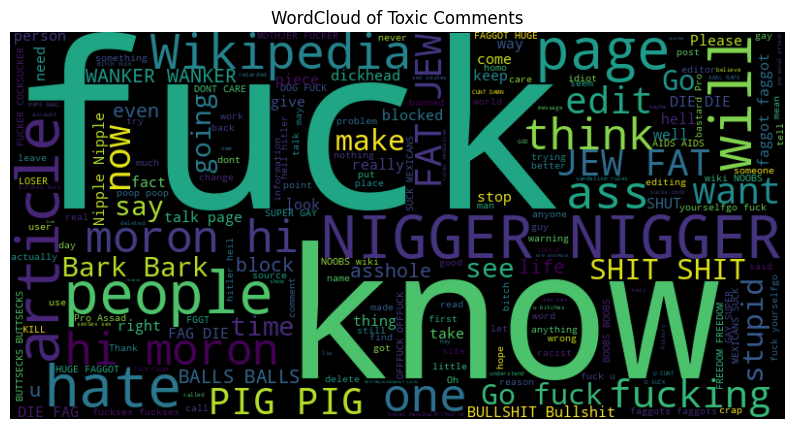

In [29]:
# Toxic only
toxic_comments = Dataset[Dataset['any_label']==1]['comment_text']

toxic_text = " ".join(toxic_comments)
wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(toxic_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Toxic Comments")
plt.show()

Toxic language is strongly characterized by profanity and slurs, while clean comments focus on knowledge-sharing and cooperative discussion

#### 5. Sentiments analysis

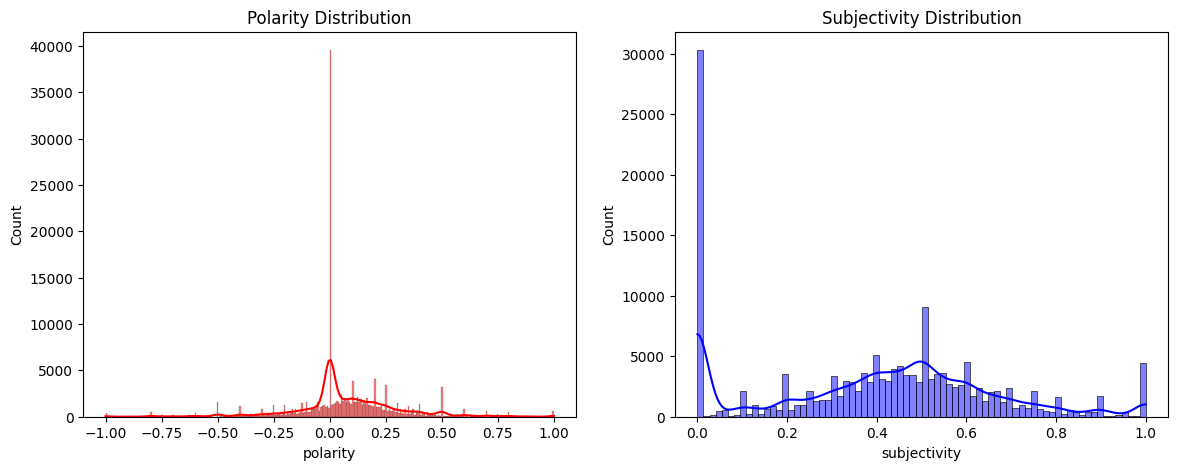

            polarity   subjectivity
count  159571.000000  159571.000000
mean        0.073185       0.397921
std         0.239458       0.264189
min        -1.000000       0.000000
25%         0.000000       0.200000
50%         0.030000       0.430000
75%         0.192857       0.566667
max         1.000000       1.000000


In [30]:
dataset_eda['polarity'] = dataset_eda['comment_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
dataset_eda['subjectivity'] = dataset_eda['comment_text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(dataset_eda['polarity'], kde=True, ax=axes[0], color="red").set(title="Polarity Distribution")
sns.histplot(dataset_eda['subjectivity'], kde=True, ax=axes[1], color="blue").set(title="Subjectivity Distribution")
plt.show()

print(dataset_eda[['polarity','subjectivity']].describe())

Polarity is not a reliable feature, as both toxic and non-toxic comments cluster near neutral values, leading to heavy overlap.However, subjectivity can provide additional signals, as toxic comments tend to be either very objective (direct insults) or moderately subjective (opinionated abuse).



### Bivariate Analysis

#### 1. Number of words

In [31]:
toxic_word_count = dataset_eda.loc[dataset_eda["any_label"]==1, "words_count"].astype(int)
non_toxic_word_count = dataset_eda.loc[dataset_eda["any_label"]==0, "words_count"].astype(int)

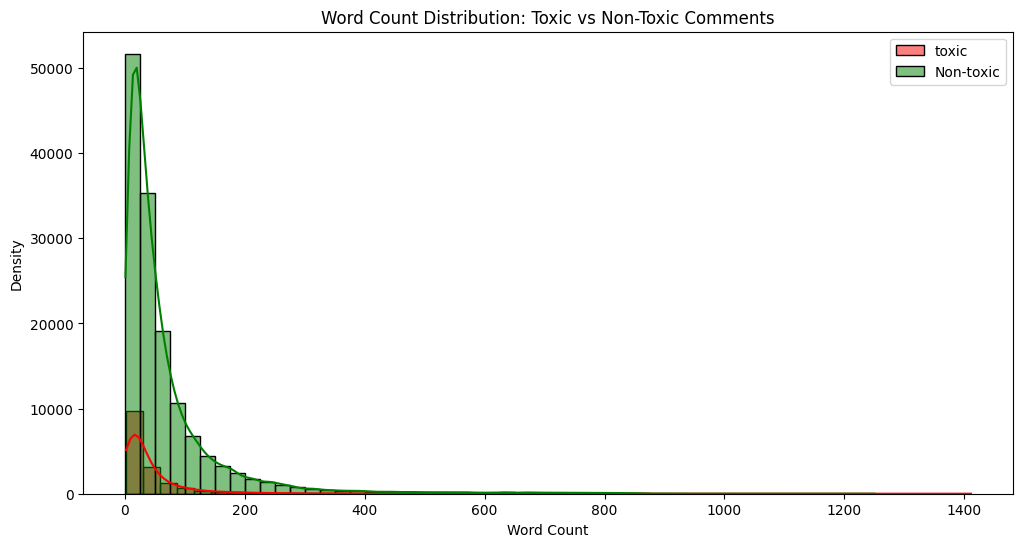

In [32]:
plt.figure(figsize=(12,6))

sns.histplot(toxic_word_count, label = 'toxic', bins=50, kde=True, color="red")
sns.histplot(non_toxic_word_count, label = 'Non-toxic', bins=50, kde=True, color="green")

plt.title("Word Count Distribution: Toxic vs Non-Toxic Comments")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.legend()
plt.show()

On average, toxic comments are shorter, though some long toxic outliers exist (e.g., extended abusive rants)

#### 2. Number of characters

In [33]:
toxic_chars = dataset_eda.loc[dataset_eda["any_label"]==1, "char_count"]
non_toxic_chars = dataset_eda.loc[dataset_eda["any_label"]==0, "char_count"]

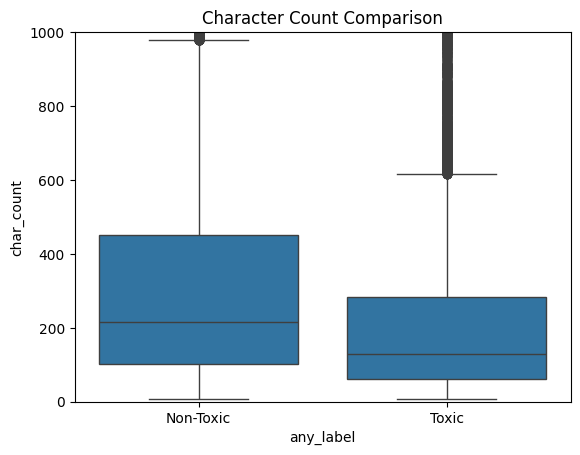

In [34]:
sns.boxplot(x=dataset_eda["any_label"], y=dataset_eda["char_count"])
plt.xticks([0,1], ["Non-Toxic", "Toxic"])
plt.ylim(0, 1000)
plt.title("Character Count Comparison")
plt.show()

Boxplot analysis shows that toxic comments have shorter character length compared to non-toxic ones, though few long toxic comments exist as outliers, likely due to extended abusive rants.

#### 3. Sentence count

In [35]:
toxic_sentence = dataset_eda.loc[dataset_eda["any_label"]==1, "sentence_count"]
non_toxic_sentence = dataset_eda.loc[dataset_eda["any_label"]==0, "sentence_count"]

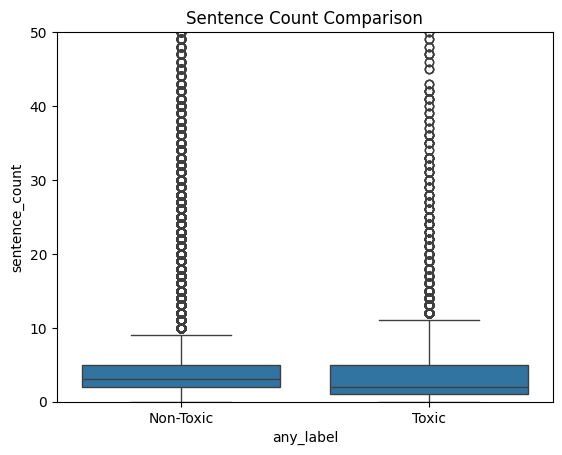

In [36]:
sns.boxplot(x=dataset_eda["any_label"], y=dataset_eda["sentence_count"])
plt.xticks([0,1], ["Non-Toxic", "Toxic"])
plt.ylim(0, 50)
plt.title("Sentence Count Comparison")
plt.show()

Both categories have extreme cases. But Toxic comments are usually shorter and sharper (fewer sentences). Non-toxic comments are more elaborative, sometimes extending into long discussions.

#### 4. Count of punctuations

In [37]:
toxic_punc = dataset_eda.loc[dataset_eda["any_label"]==1, "punctuation_count"]
non_toxic_punc = dataset_eda.loc[dataset_eda["any_label"]==0, "punctuation_count"]

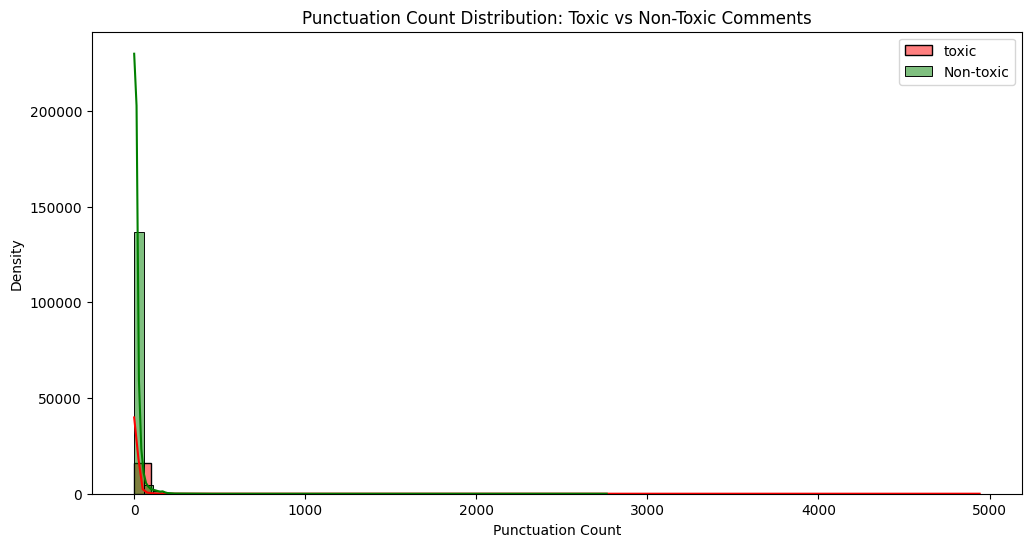

In [38]:
plt.figure(figsize=(12,6))

sns.histplot(toxic_punc, label = 'toxic', bins=50, kde=True, color="red")
sns.histplot(non_toxic_punc, label = 'Non-toxic', bins=50, kde=True, color="green")

plt.title("Punctuation Count Distribution: Toxic vs Non-Toxic Comments")
plt.xlabel("Punctuation Count")
plt.ylabel("Density")
plt.legend()

plt.show()

In [39]:
print('The mean of punctuation count of toxic comments:',np.mean(toxic_punc))
print('The mean of punctuation count of non toxic comments:',np.mean(non_toxic_punc))

The mean of punctuation count of toxic comments: 14.576394453004623
The mean of punctuation count of non toxic comments: 16.033583078704673


The overall punctuation count is higher in non-toxic comments because they are generally longer and more structured. Hence, punctuation count as a whole is not a strong indicator of toxicity. However, certain punctuation marks (like excessive exclamation marks, hashtags or user mentions) may carry more significance and could be considered as separate features.

#### 5. Number of Hashtag

In [40]:
toxic_hashtag = dataset_eda.loc[dataset_eda["any_label"]==1, "hashtag_count"]
non_toxic_hashtag = dataset_eda.loc[dataset_eda["any_label"]==0, "hashtag_count"]

In [41]:
print('-'*50)
print('Toxic comment hashtag mean',toxic_hashtag.mean())
print('Non Toxic comment hashtag mean',non_toxic_hashtag.mean())
print('-'*50)

--------------------------------------------------
Toxic comment hashtag mean 0.015963020030816642
Non Toxic comment hashtag mean 0.041668410698589425
--------------------------------------------------


Toxic comments have more number of hashtags as compared to Non toxic comments. So, this can be a useful feature.

#### 6. Number of mentions

In [42]:
toxic_mentions = dataset_eda.loc[dataset_eda["any_label"]==1, "mentions_count"]
non_toxic_mentions = dataset_eda.loc[dataset_eda["any_label"]==0, "mentions_count"]

In [43]:
print('-'*50)
print('Toxic comment hashtag mean',toxic_mentions.mean())
print('Non Toxic comment hashtag mean',non_toxic_mentions.mean())
print('-'*50)

--------------------------------------------------
Toxic comment hashtag mean 0.02403697996918336
Non Toxic comment hashtag mean 0.008817825401476149
--------------------------------------------------


#### 7. Number of asterisk


In [44]:
toxic_asterisk = dataset_eda.loc[dataset_eda["any_label"]==1, "asterisk_count"]
non_toxic_asterisk = dataset_eda.loc[dataset_eda["any_label"]==0, "asterisk_count"]

In [45]:
print('-'*50)
print('Toxic comment asterisk_count mean',toxic_asterisk.mean())
print('Non Toxic comment asterisk_count mean',non_toxic_asterisk.mean())
print('-'*50)

--------------------------------------------------
Toxic comment asterisk_count mean 0.09152542372881356
Non Toxic comment asterisk_count mean 0.026439523949046362
--------------------------------------------------


Above observations clearly shows that the number of '*' and '#' are more in toxic comments. They can be useful features

### Multivariate Analysis

#### Heatmap

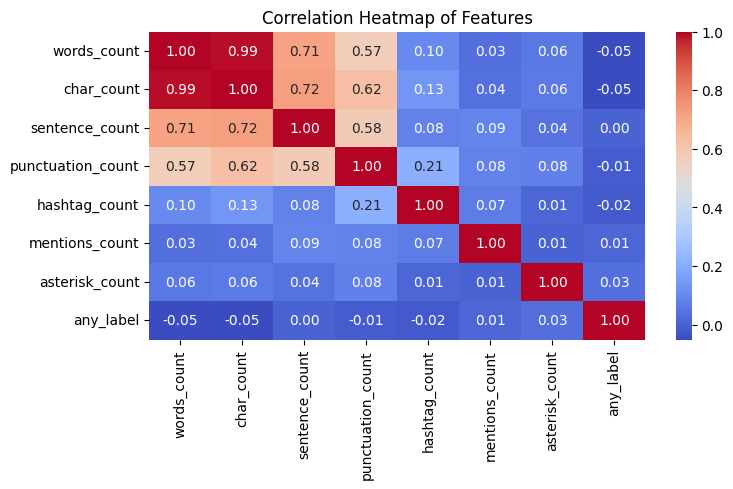

In [46]:
corr = dataset_eda[['words_count','char_count','sentence_count',
                    'punctuation_count','hashtag_count','mentions_count',
                    'asterisk_count','any_label']].corr()
plt.figure(figsize=(8,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

Words count and characters count are highly correlated (≈0.99), making them redundant. Sentence count is also strongly correlated with these, while punctuation, hashtags, mentions, and asterisks provide unique signals.

# Text Preprocessing

In [47]:
features_df = Dataset.copy()

In [48]:
#Exploring the comment text
features_df.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

<p>We can observe the comment text is contracted resulting in words like 'weren't', 'I'm' , etc. This needs to be corrected. So, I will expand it.
<br><br>
Example - weren't = were not</p>

In [49]:
!pip install contractions
import contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.1 MB/s eta 0:00:00


In [50]:
features_df['preprocessed_text'] = features_df['comment_text'].apply(lambda x: contractions.fix(x))

In [51]:
features_df['preprocessed_text'][0]

'Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They were not vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please do not remove the template from the talk page since I am retired now.89.205.38.27'

In [52]:
#Lemmatizer will reduce a word to its base form. For example words like playing, played, plays will have a base word 'play'
lemmatizer = WordNetLemmatizer()

#stopwords contains words like the, this, is, are which will hold no meaning in the comment
stopword = set(nltk.corpus.stopwords.words('english')) - {"no", "not", "nor"}  # keep negations

In [53]:
def text_cleaning(text):
    #text =  pd.Series(text)

    # 1. Replace URLs, Emails, User mentions, Hashtags
    text = re.sub(r'http\S+|www\S+', 'URL', text)         # URLs
    text = re.sub(r'\S+@\S+', 'EMAIL', text)              # Emails
    text = re.sub(r'@\w+', 'USER', text)                  # User mentions
    text = re.sub(r'#(\w+)', r'\1', text)                 # Hashtags (keep word)

    # 2. remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), " ", text)

    # 3. remove non-ascii words
    text = re.sub(r'[^\x00-\x7f]', r' ', text)

    # 4. converting to lower case
    text = text.lower()

    # 5. remove \n
    text = re.sub("\\n", ' ',text)

    # 6. This ensures only the word nbsp (surrounded by word boundaries) gets replaced, no matter where it appears.
    text = re.sub(r'\bnbsp\b', ' ', text)

    # 7. Instead of removing digits from text file we will replace it with 'NUM' to capture toxicity
    #Ex - sh1t or a55hole will become shNUMt or aNUMhole
    text = re.sub(r'\d+', 'NUM', text)

    # 8. splitting sentence into tokens
    text_tokens = text.split()

    # 9. converting the word to its meaningful base form
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text_tokens]

    # 10. removing stopword from sentence
    cleaned_tokens = [w for w in lemmatized_text if w not in stopword]

    #Rejoin and clean extra spaces
    text = ' '.join(cleaned_tokens)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [54]:
features_df['preprocessed_text'] = features_df['preprocessed_text'].apply(lambda x: text_cleaning(x))

In [55]:
features_df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [56]:
features_df['preprocessed_text'][0]

'explanation edits made username hardcore metallica fan reverted not vandalism closure gas voted new york doll fac please not remove template talk page since retired NUM NUM NUM NUM'

# Feature Encoding

## Extracting features from text

In [57]:
# 1. Number of sentence per comment
features_df['sentence_count'] = features_df["comment_text"].apply(
    lambda x: len(re.findall(r'[.!?\n]+', str(x))) )

# 2. Word count in each comment:
features_df['word_counts'] = features_df["preprocessed_text"].apply(
    lambda x: len(str(x).split()))

# 3. Unique word count
features_df['unique_word_count'] = features_df["preprocessed_text"].apply(
    lambda x: len(set(str(x).split())))

# 4. Average length of the words
features_df['avg_word_len'] = features_df["preprocessed_text"].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

# 5. upper case letters count
features_df["uppercase_char_count"] = features_df["comment_text"].apply(
    lambda x: sum(1 for c in str(x) if c.isupper()))

# 6. uppercase word count
features_df["uppercase_word_counts"] = features_df["comment_text"].apply(
    lambda x: sum(1 for w in str(x).split() if w.isupper()))

# 7. Number of hashtags in the text
features_df['hashtags_count'] = features_df["comment_text"].apply(
    lambda x: len([t for t in x.split() if t.startswith('#')]))

# 8. Number of mentions in the text
features_df['mentions_count'] = features_df["comment_text"].apply(
    lambda x: len([t for t in x.split() if t.startswith('@')]))

# 9.Number of asterisk in the text
features_df['asterisk_count'] = features_df["comment_text"].apply(
    lambda x: len([t for t in x.split() if t.startswith('*')]))

# 10. Number of digits per comment
features_df['digits_count'] = features_df['comment_text'].apply(
    lambda x: sum(c.isdigit() for c in str(x)))

# 11. stopwords count
features_df['stopword_count'] = features_df["comment_text"].apply(
    lambda x: sum(1 for w in str(x).split() if w in stopword))

# 12. Sentiment features using TextBlob
features_df['TextBlob_Subjectivity'] = features_df["comment_text"].apply(
    lambda x: TextBlob(x).sentiment.subjectivity) #weak features

features_df['TextBlob_Polarity'] = features_df["comment_text"].apply(
    lambda x: TextBlob(x).sentiment.polarity)  #weak features

features_df['TextBlob_Analysis'] = features_df['TextBlob_Polarity'].apply(
    lambda x: -1 if x<0 else (1 if x>0 else 0))  #weak features

In [58]:
features_df.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'any_label', 'preprocessed_text', 'sentence_count',
       'word_counts', 'unique_word_count', 'avg_word_len',
       'uppercase_char_count', 'uppercase_word_counts', 'hashtags_count',
       'mentions_count', 'asterisk_count', 'digits_count', 'stopword_count',
       'TextBlob_Subjectivity', 'TextBlob_Polarity', 'TextBlob_Analysis'],
      dtype='object')

From the n-gram analysis in EDA, we observed that toxic comments frequently contain abusive unigrams (e.g., fuck, shit), bigrams (e.g., shut up, kill yourself), and trigrams (e.g., fuck fuck fuck).
Based on these insights, we now create features that capture the presence of such toxic words and phrases, and also use TF-IDF with uni/bi/tri-grams for richer text representation.

In [59]:
#splitting the dataset here to avoid data leakage

train_df, test_df = train_test_split(
    features_df,
    test_size=0.2,
    random_state=42,
    stratify=Dataset['any_label']  # keep toxic/non-toxic balance
)

In [60]:
clean_data = train_df[train_df['any_label']==0]
toxic_data = train_df[train_df['any_label']==1]

In [61]:
#function to get top n grams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:15]

In [62]:
label_top_words = {}

for label in labels:
    label_data = train_df[train_df[label] == 1]

    # Unigrams
    top_uni_grams = get_top_ngram(label_data['preprocessed_text'], n=1)
    if top_uni_grams:
        unigrams, _ = map(list, zip(*top_uni_grams))
    else:
        unigrams = []

    # Bigrams
    top_bi_grams = get_top_ngram(label_data['preprocessed_text'], n=2)
    if top_bi_grams:
        bigrams, _ = map(list, zip(*top_bi_grams))
    else:
        bigrams = []

    # Trigrams
    top_tri_grams = get_top_ngram(label_data['preprocessed_text'], n=3)
    if top_tri_grams:
        trigrams, _ = map(list, zip(*top_tri_grams))
    else:
        trigrams = []

    # Merge them all (remove duplicates with set)
    label_top_words[label] = list(set(unigrams + bigrams + trigrams))

# Assign lists for convenience
toxic_words_list         = label_top_words.get('toxic', [])
severe_toxic_list        = label_top_words.get('severe_toxic', [])
obscene_words_list       = label_top_words.get('obscene', [])
threat_words_list        = label_top_words.get('threat', [])
insult_words_list        = label_top_words.get('insult', [])
identity_hate_words_list = label_top_words.get('identity_hate', [])


we can clearly see that words like nigger, jew, fat, gay, fuck, die, fucking, nigga, suck, shit, suck, faggot, bitch, cunt, moron, die, kill, block, ban, dick, cock are repeated most in toxic comments

In [63]:
train_df['toxic_words_count']         = train_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in toxic_words_list))
train_df['severe_toxic_count']        = train_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in severe_toxic_list))
train_df['obscene_words_count']       = train_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in obscene_words_list))
train_df['threat_words_count']        = train_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in threat_words_list))
train_df['insult_words_count']        = train_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in insult_words_list))
train_df['identity_hate_words_count'] = train_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in identity_hate_words_list))

In [64]:
train_df.shape

(127656, 29)

In [65]:
test_df['toxic_words_count'] = test_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in toxic_words_list))
test_df['severe_toxic_count'] = test_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in severe_toxic_list))
test_df['obscene_words_count'] = test_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in obscene_words_list))
test_df['threat_words_count'] = test_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in threat_words_list))
test_df['insult_words_count'] = test_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in insult_words_list))
test_df['identity_hate_words_count'] = test_df['preprocessed_text'].apply(lambda x: sum(word in x.split() for word in identity_hate_words_list))

In [66]:
test_df.shape

(31915, 29)

In [67]:
# Save train and test datasets
train_df.to_csv("/content/drive/MyDrive/TCC/train_features.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/TCC/test_features.csv", index=False)

# Advanced Feature Encoding

### Feature Encoding using TF-IDF

In [68]:
# TF-IDF Vectorizer (unigram + bigram for better performance)
tfidf = TfidfVectorizer(max_features= 5000, ngram_range=(1,2))

# Fit on training data only
X_train_tfidf = tfidf.fit_transform(train_df['preprocessed_text'])
X_test_tfidf = tfidf.transform(test_df['preprocessed_text'])

# Target labels
y_train = train_df[labels]
y_test = test_df[labels]

print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)


Train TF-IDF shape: (127656, 5000)
Test TF-IDF shape: (31915, 5000)


### Feature Encoding using Word2Vec

In [69]:
from gensim.models import Word2Vec

# Tokenize comments
sentences = [row.split() for row in train_df['preprocessed_text']]

# Train Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Average embedding for each comment
def vectorize(comment):
    words = comment.split()
    vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if len(vecs)>0 else np.zeros(100)

w2v_features = np.vstack([vectorize(c) for c in train_df['preprocessed_text']])
print("Word2Vec feature matrix shape:", w2v_features.shape)

Word2Vec feature matrix shape: (127656, 100)


### Feature Encoding using GLOVE

In [70]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-09-24 04:58:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.09MB/s    in 2m 40s  

2025-09-24 05:01:24 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [71]:
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
print("Loaded %s word vectors." % len(embeddings_index))


Loaded 400000 word vectors.


In [72]:
def glove_vectorize(text):
    words = text.split()
    vecs = [embeddings_index[w] for w in words if w in embeddings_index]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(100)

X_train_glove = np.vstack([glove_vectorize(c) for c in train_df['preprocessed_text']])
X_test_glove  = np.vstack([glove_vectorize(c) for c in test_df['preprocessed_text']])

print("GloVe embeddings shape:", X_train_glove.shape)


GloVe embeddings shape: (127656, 100)


#### Saving the trained model and features

In [73]:
import joblib, pickle
import numpy as np
from scipy import sparse

# === TF-IDF ===
joblib.dump(tfidf, "/content/drive/MyDrive/TCC/tfidf_vectorizer.pkl")
sparse.save_npz("/content/drive/MyDrive/TCC/X_train_tfidf.npz", X_train_tfidf)
sparse.save_npz("/content/drive/MyDrive/TCC/X_test_tfidf.npz", X_test_tfidf)

# === Word2Vec ===
w2v_model.save("/content/drive/MyDrive/TCC/word2vec.model")
np.save("/content/drive/MyDrive/TCC/X_train_w2v.npy", w2v_features)

# === GloVe ===
with open("/content/drive/MyDrive/TCC/glove_embeddings.pkl", "wb") as f:
    pickle.dump(embeddings_index, f)
np.save("/content/drive/MyDrive/TCC/X_train_glove.npy", X_train_glove)
np.save("/content/drive/MyDrive/TCC/X_test_glove.npy", X_test_glove)


# High-dimensional data visualization

#### Let us try to visualize data in 2D using TSNE

In [74]:
train_df.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'any_label', 'preprocessed_text', 'sentence_count',
       'word_counts', 'unique_word_count', 'avg_word_len',
       'uppercase_char_count', 'uppercase_word_counts', 'hashtags_count',
       'mentions_count', 'asterisk_count', 'digits_count', 'stopword_count',
       'TextBlob_Subjectivity', 'TextBlob_Polarity', 'TextBlob_Analysis',
       'toxic_words_count', 'severe_toxic_count', 'obscene_words_count',
       'threat_words_count', 'insult_words_count',
       'identity_hate_words_count'],
      dtype='object')

In [75]:
feature_list = [
    'sentence_count', 'word_counts', 'unique_word_count', 'avg_word_len',
    'uppercase_char_count', 'uppercase_word_counts', 'hashtags_count',
    'mentions_count', 'asterisk_count', 'digits_count', 'stopword_count',
    'TextBlob_Subjectivity', 'TextBlob_Polarity', 'TextBlob_Analysis',
    'toxic_words_count', 'severe_toxic_count', 'obscene_words_count',
    'threat_words_count', 'insult_words_count', 'identity_hate_words_count'
]

train_features = train_df[feature_list].copy()
test_features  = test_df[feature_list].copy()

In [76]:
train_features.shape

(127656, 20)

### T-Sne on Handcrafted Features

In [77]:
tsne = TSNE(n_components = 2,  # reduce to 2D for visualization
            perplexity = 30,   # typically 5–50 (depends on dataset size)
            max_iter = 1000,
            random_state = 42)

X_embedded_features = tsne.fit_transform(train_features[:10000])
# convert sparse matrix → dense array

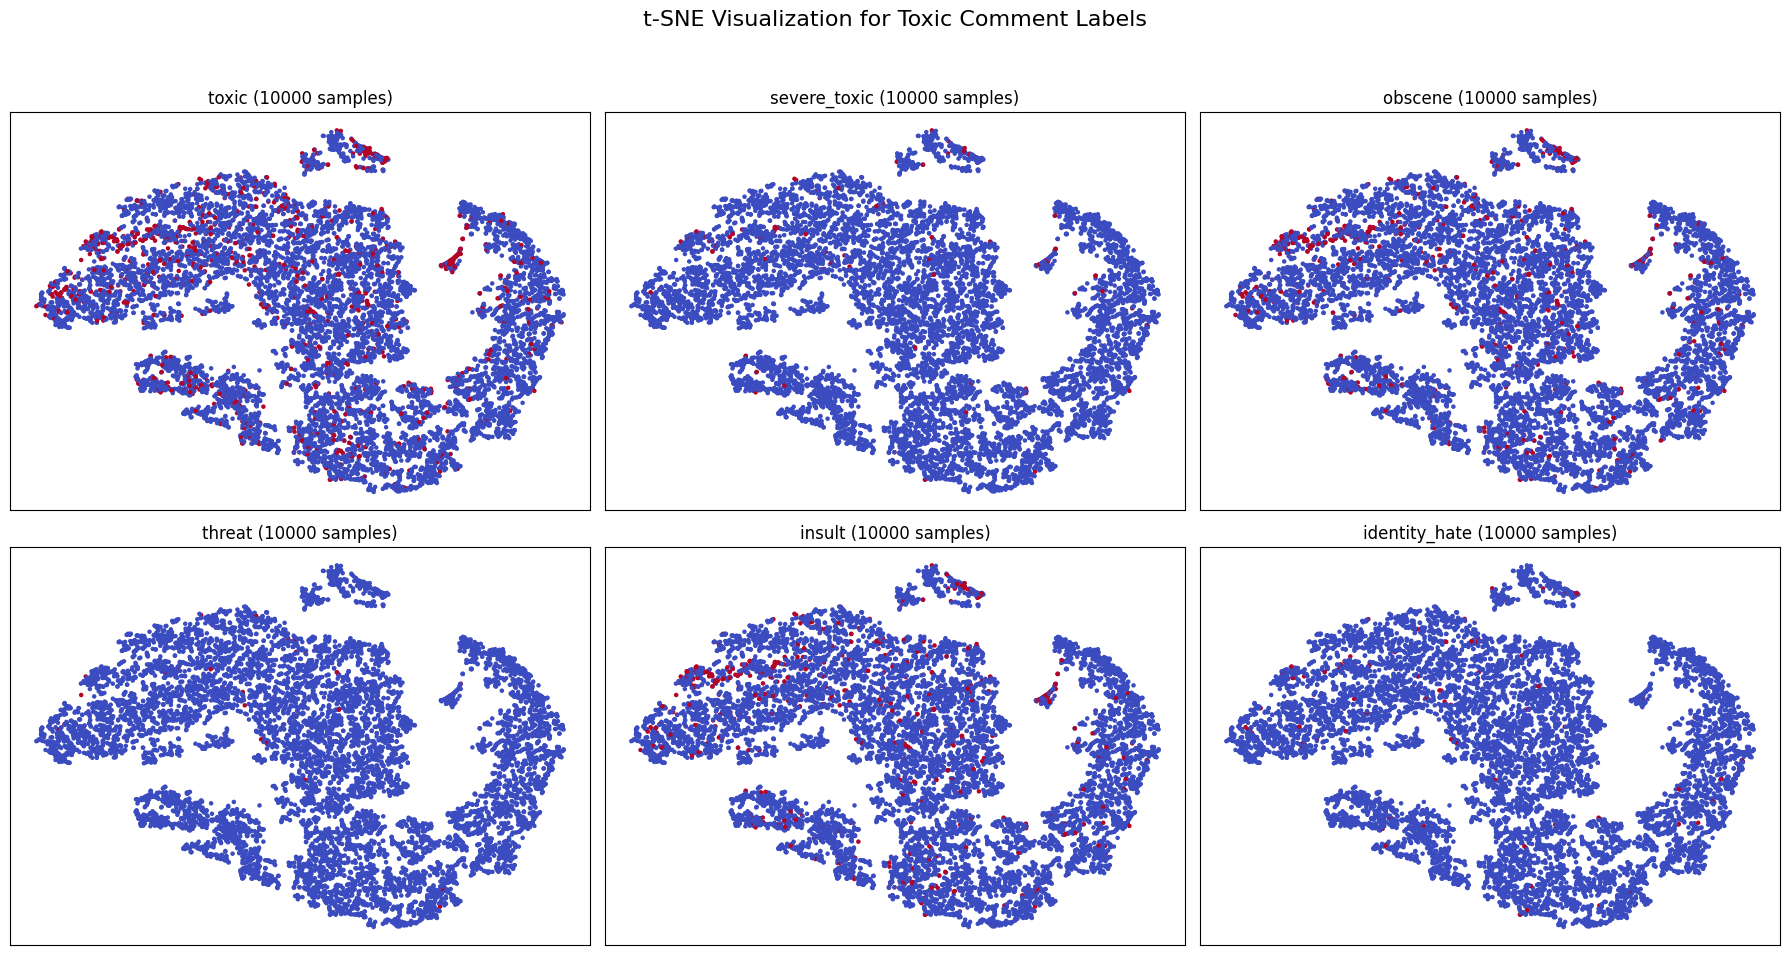

In [78]:
# Grid setup (2 rows × 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, label in zip(axes.ravel(), labels):
    scatter = ax.scatter(X_embedded_features[:,0], X_embedded_features[:,1],
                         s=5,
                         c=y_train[label][:10000].values,
                         cmap="coolwarm")
    ax.set_title(f"{label} (10000 samples)")
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout
plt.suptitle("t-SNE Visualization for Toxic Comment Labels", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

toxic and non-toxic comments are heavily mixed. While there is partial separation for common labels such as toxic, obscene, and insult, the minority classes (threat and identity_hate) remain highly scattered due to their extremely low frequency.

This confirms that manual handcrafted features alone are insufficient to clearly separate toxic vs. clean comments in an unsupervised setting.

### T-Sne on TFIDF

In [79]:
tsne = TSNE(n_components = 2,  # reduce to 2D for visualization
            perplexity = 30,   # typically 5–50 (depends on dataset size)
            max_iter = 1000,
            random_state = 42)

# convert sparse matrix → dense array
X_embedded = tsne.fit_transform(X_train_tfidf[:10000].toarray())

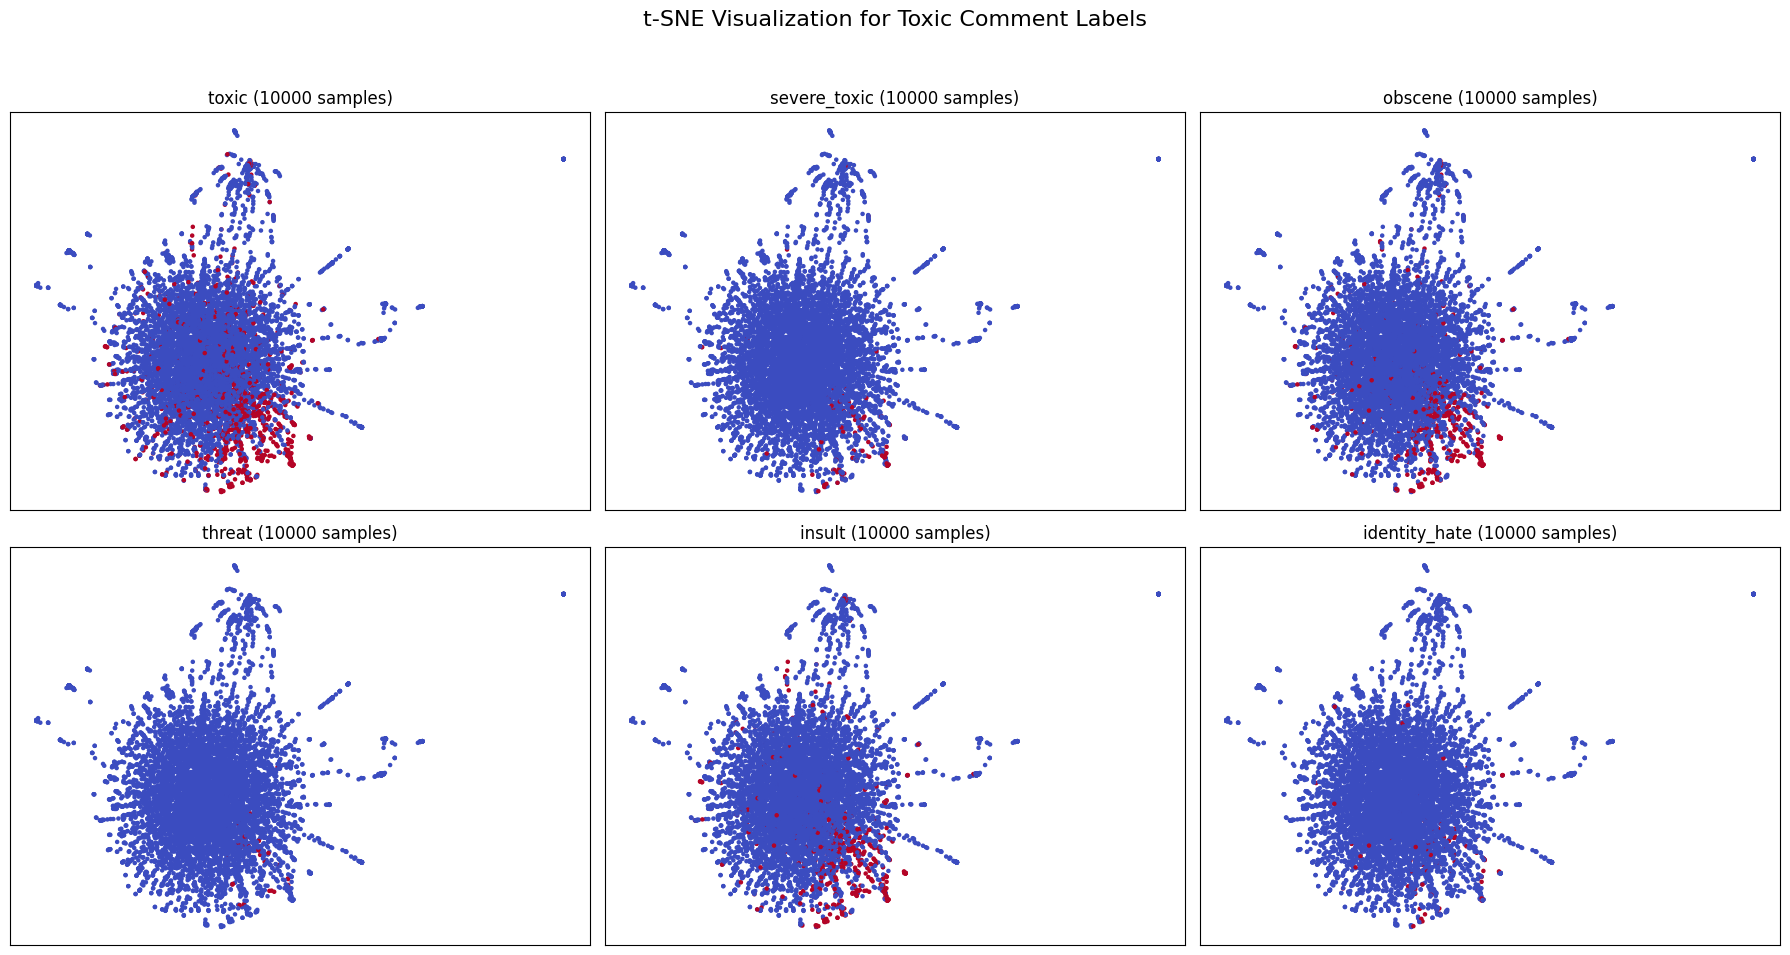

In [82]:
# Grid setup (2 rows × 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, label in zip(axes.ravel(), labels):
    scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1],
                         s=5,
                         c=y_train[label][:10000].values,
                         cmap="coolwarm")
    ax.set_title(f"{label} (10000 samples)")
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout
plt.suptitle("t-SNE Visualization for Toxic Comment Labels", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The t-SNE visualization shows that toxic and non-toxic comments are heavily mixed, with only partial separation for categories like **toxic, obscene, and insult**. Rare labels such as **threat** and **identity hate** fail to form distinct clusters due to extreme class imbalance and limited samples. This indicates that **frequency-based features (TF-IDF) are insufficient to capture deeper semantics of toxic language**. To improve separability, **advanced encodings (Word2Vec, BERT) and supervised classification models with imbalance handling** will be required.

### T-Sne on word2vec

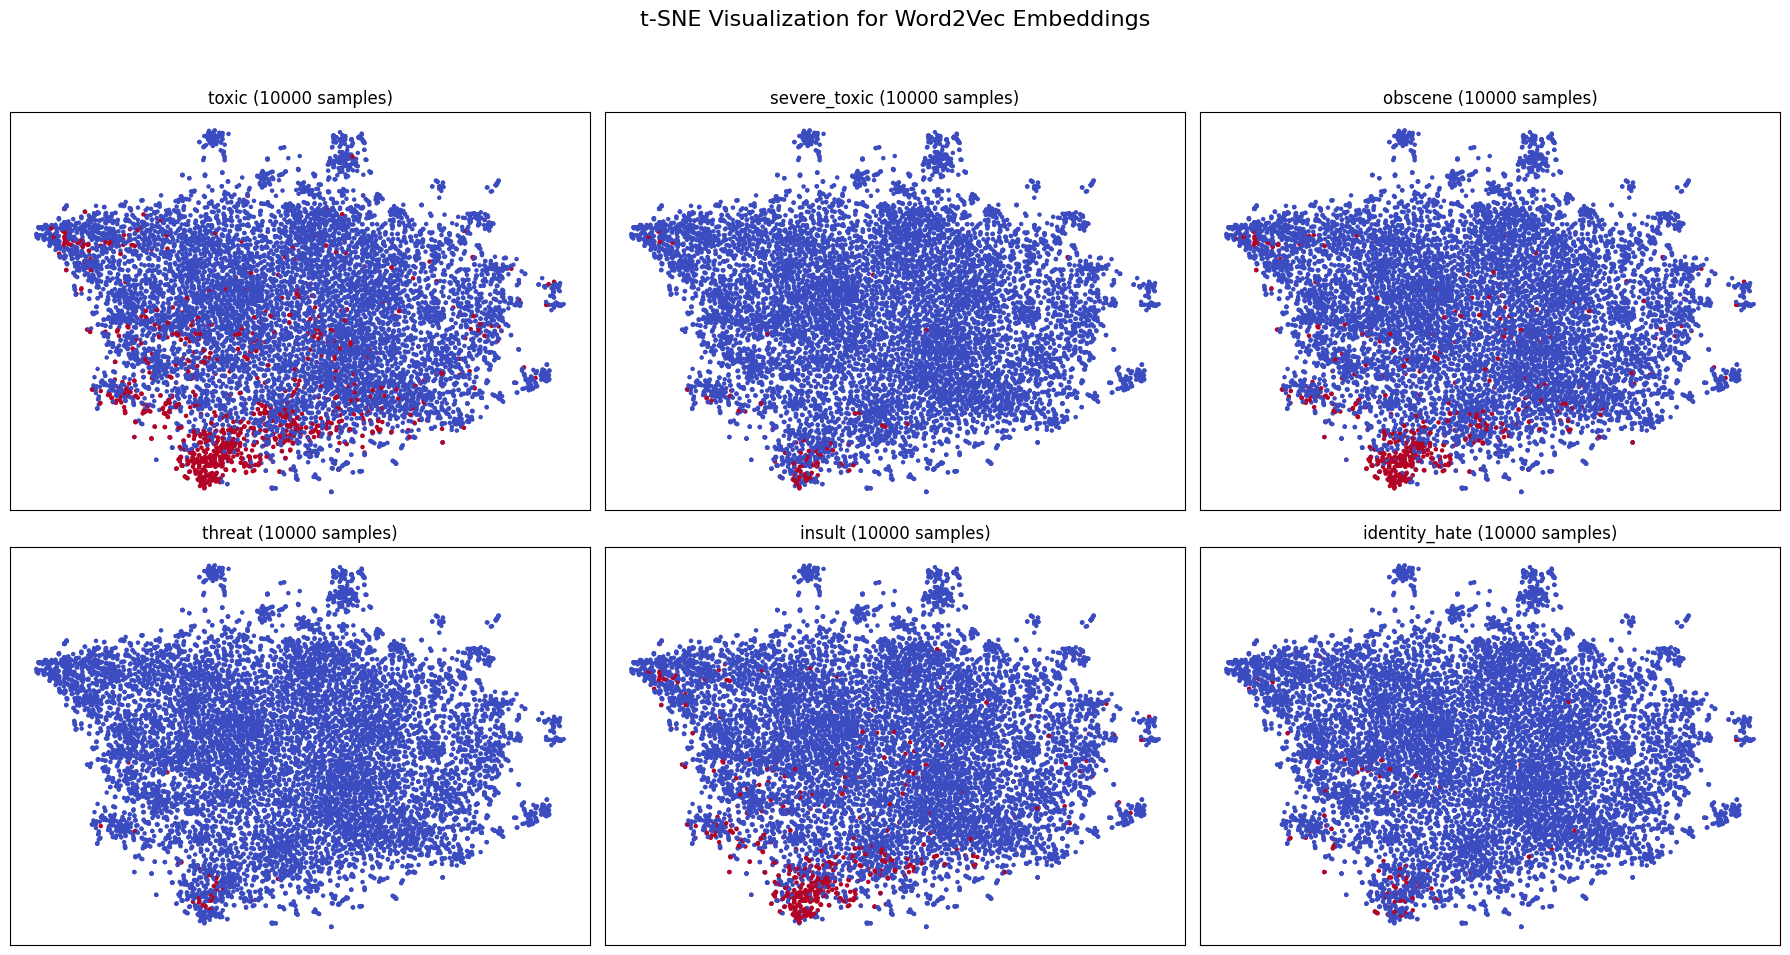

In [81]:
# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_embedded_w2v = tsne.fit_transform(w2v_features[:10000])

# Plot per label
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, label in zip(axes.ravel(), labels):
    scatter = ax.scatter(X_embedded_w2v[:, 0], X_embedded_w2v[:, 1],
                         s=5,
                         c=y_train[:10000][label].values,
                         cmap="coolwarm")
    ax.set_title(f"{label} ({10000} samples)")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("t-SNE Visualization for Word2Vec Embeddings", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The t-SNE visualization of Word2Vec embeddings shows small but denser patches of toxic comments for frequent labels (toxic, obscene, insult), suggesting that semantic embeddings capture context better than TF-IDF. However, heavy overlap with non-toxic samples remains, and minority categories (threat, identity_hate) are too sparse to form meaningful clusters.

This indicates that while Word2Vec provides stronger representations than manual features or TF-IDF, unsupervised visualization alone cannot achieve clear class separation.

# Conclusion

1. The toxic comment dataset is multi-label and severely imbalanced, with minority classes underrepresented.

2. Toxic comments are generally shorter, sharper, and dominated by abusive/unpleasant words.

3. Manual and sentiment features provide limited separation between toxic and non-toxic comments.

4. TF-IDF and Word2Vec capture richer patterns but still show heavy overlap in unsupervised t-SNE plots.

5. Supervised models with imbalance handling are essential for effective toxic comment classification.


